## Python statistics essential training - 04_02_confidenceintervals

In [1]:
#meta 4/19/2020
#Ch4. Statistical Inference
#my code and solution code bits

In [2]:
import math
import io

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import scipy.stats
import scipy.optimize
import scipy.spatial

# Ch 4. Statistical Inference
Describes the process of drawing conclusions from data and of understanding the confidence we may have in those conclusions. In chapter 3, we discussed many ways to describe the variation in variables using both descriptive statistics and diff kinds of plots. In this chapter, we worry about the uncertainty in our statements about variation. The uncertainty arises because we can only study a limited sample of the population that we really want to find about.

For instance, we may wonder about all the extra solar planets in our galaxy. But we can only compute statistics for those that we have observed through telescopes. We learn how simple mathematics and computer simulations can be used to understand the randomness due to limited samples. A separate issue is whether the sample is representative of a population. For instance, it is much easier to detect large extra solar planets, so large planets would be over-represented in our sample and skew the resulting population statistics.

This selection effects can be addressed mathematically or by improving our data taking. Both topics are outside the scope of this course (see statistics text books).

# Confidence Intervals

Scenario: A very important election is taking place in your city with an incumbent mayor, Mr. Brown, against the local celebrity chef, Mrs. Green. You work for the local newspaper, and you're asked to poll your co-citizens for their vote. To make things easy for you, we'll assume you can reach every voter by phone and that every poll voter replies truthfully. (Both are not trivial assumptions in reality, but in this case, there are no selection effects.)  

Laboriously, you call 1,000 voters and ask for their voting intention. 


## 0. Load Data
Start with a sample of 1000 votes

In [5]:
poll = pd.read_csv('lynda_data/poll.csv')
poll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
vote    1000 non-null object
dtypes: object(1)
memory usage: 7.9+ KB


In [6]:
poll.head()

,vote
0,Brown
1,Green
2,Brown
3,Brown
4,Brown


## 1. Analyze Data

In [7]:
#get proportions for each candidate
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

#### Sampling variability
The data seem to say that Brown is going to remain mayor. However, the limited sample means that the proportion depends on the specific people that you happen to draw. This is known as sampling variability.

So given this poll, what can you really say about the underlying population of voters?  We need to study the sampling distribution of the proportion, namely, we wish to understand what range of different samples we may get for the same population, and we'll do this by simulation on a computer. 

In [8]:
#np.random.rand(n) returns a vector of random numbers between 0 and 1, size n.
np.where(np.random.rand(10) < 0.51, 'Brown', 'Green')

array(['Green', 'Green', 'Green', 'Green', 'Green', 'Green', 'Green',
       'Brown', 'Green', 'Brown'], dtype='<U5')

In [9]:
#build a simple function that simulates such a sample
#input: 
#  -the actual fraction of votes for Mayor Brown 
#  -the number of people polled
#output:
#  -votes for either Brown or Green

def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < brown, 'Brown', 'Green')})

In [10]:
#get one possible sample and the counts for two candidates
s = sample(0.51, n=100)
s.vote.value_counts(normalize=True)

Brown    0.58
Green    0.42
Name: vote, dtype: float64

Sometimes, Brown is actually under the level of winning the election, although is True fraction is .51. For example:  
Green    0.55  
Brown    0.45  

Repeat many times and collect the results.  1000 simulated experiments should be sufficient.

In [11]:
dist = pd.DataFrame([sample(0.51).vote.value_counts(normalize=True) for i in range(1000)])
dist.head(2)

,Brown,Green
vote,0.538,0.462
vote,0.519,0.481


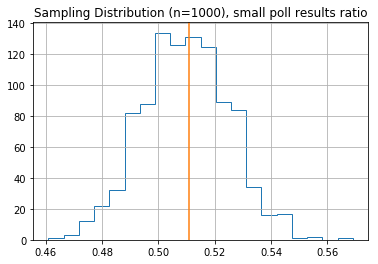

In [12]:
dist.Brown.hist(histtype='step', bins=20)
plt.title("Sampling Distribution (n=1000), small poll results ratio")
plt.axvline(0.511,c='C1')
plt.draw()

It turns out that for a True Brown fraction of .51, we may obtain any sample proportion from .48 to .54.  The converse must be true also, so that .51 that you observe may actually originate from a Green majority. 

Can we make this more precise and identify a likely range of True fractions? 

#### Confidence interval

95% confidence interval:  
- built from data  
- contains the true value of a population parameter 95% of the time  
- over many similar experiments

The confidence interval describes the uncertainty of inference by giving us a range such that saying 95% of the times, the range would include the True value. 95% is the confidence level means that if we were to make polls in 100 elections and compute the confidence interval for each election, then for approximately 95 of those 100, the intervals would include a True value.

Of course, we wouldn't know which 95. A confidence interval is formed from the data in such a way that 95% of the times, it would include the True value. 

Next, simulate the sampling distribution for any True Brown fraction.

In [13]:
def samplingdist(brown,n=1000):
    return pd.DataFrame([sample(brown,n).vote.value_counts(normalize=True) for i in range(1000)])

Let's say we want to go for the 95% confidence interval. This will lie between the 2.5% quantile and the 97.5% quantile.

So we look for the True fraction for which a measured value of .51 lies at a 2.5% quantile, and the True fraction for which our measured value lies at the 97.5 quantile. It turns out that those two fractions are the edges of the confidence interval. If you think about many different experiments where we repeat this procedure, you can convince yourself that this is indeed the case. So I'll make a function that extracts those quantiles by first calling samplinglist and then calling DataFrame quantile on it.


In [14]:
def quantiles(brown,n=1000):
    dist = samplingdist(brown,n)
    return dist.Brown.quantile(0.025), dist.Brown.quantile(0.975)

Let's explore a few values until we find .51 on each end. We do this approximately. 

In [15]:
print(quantiles(0.50))
print(quantiles(0.48)) #lower interval
print(quantiles(0.54)) #upper interval

(0.468975, 0.53)
(0.451, 0.511025)
(0.508, 0.571)


So, for an observed sample, proportion of .51, when the sample size is 1,000, the 95 confidence interval for the True population function is .48 to .54.

#### 95% confidence interval : [0.48, 0.54]
#### Estimate = 0.51 +- 0.03 (at 95% confidence level) 
Estimate = Point estimate +- margin of error

We can say that our point estimate is .51, and that the margin of error is .03 on either side in 95% confidence. Thus, the result of this election lies within the margin of error of the poll. 


Another way to look at it:  
Create a sampling distribution for a True fraction of 50% and 1,000 samples and see where small poll average falls.


In [16]:
#create a sampling distribution for a True fraction of 50% and 10,000 samples
#dist = pd.DataFrame([sample(0.50).vote.value_counts(normalize=True) for i in range(1000)])
dist = samplingdist(0.5)
dist.head(2)

,Brown,Green
vote,0.488,0.512
vote,0.532,0.468


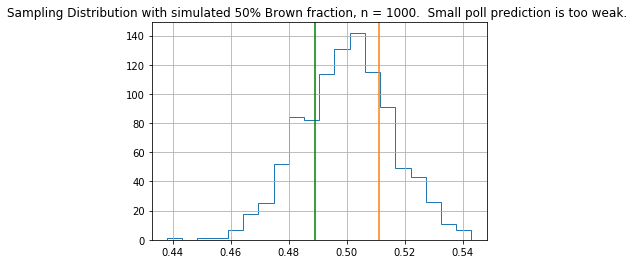

In [17]:
dist.Brown.hist(histtype='step', bins=20)
plt.title("Sampling Distribution with simulated 50% Brown fraction, n = 1000.  Small poll prediction is too weak. ")
plt.axvline(0.511,c='C1')
plt.axvline(1 - 0.511,c='g')
plt.draw()

That's not very satisfying for a journalist such as you. So we can do better by increasing the size of the sample. How much bigger would we need to be? Luckily, we have a way to simulate it.

#### How to reduce margin of error?  Collect more data.
We'll create a sampling distribution for a True fraction of 50%, and with 10,000 samples. This takes a few seconds. Let's histogram again. 

In [18]:
#create a sampling distribution for a True fraction of 50% and 10,000 samples
dist = samplingdist(0.50,10000)

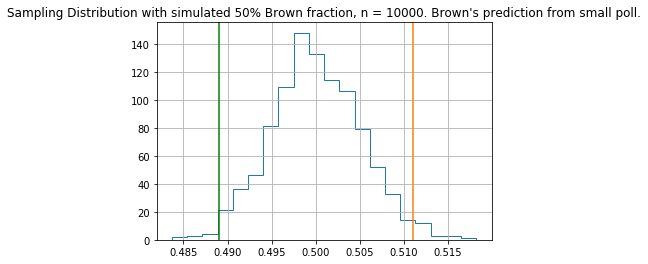

In [19]:
dist.Brown.hist(histtype='step', bins=20)
plt.title("Sampling Distribution with simulated 50% Brown fraction, n = 10000. Brown's prediction from small poll.")
plt.axvline(0.511,c='C1')
plt.axvline(1 - 0.511,c='g')
plt.draw()

You see from this, the margin of error is now more like 1%, which would have been sufficient to claim Brown as the likely winner. Under very general conditions, one can show that the margin of error improves with square root of the number of samples.

In [20]:
#include .5 (or almost)
print(quantiles(0.50, 10000))
print(quantiles(0.49, 10000)) #lower interval
print(quantiles(0.51, 10000)) #upper interval

(0.4903, 0.5099025)
(0.48, 0.4997025)
(0.500195, 0.5194025)


In [21]:
#exclude .5
print(quantiles(0.48, 10000))
print(quantiles(0.52, 10000))

(0.4699975, 0.4891)
(0.5102975, 0.5306)


But we actually have to collect the sample. 

## 0. Load Data
Get a larger sample of 10000 votes

In [22]:
largepoll = pd.read_csv('lynda_data/poll-larger.csv')
largepoll.shape

(10000, 1)

## 1. Analyze Data

In [23]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

And we find out that the likely winner is, in fact, Mrs. Green. If we were to compute the confidence interval for the Green fraction in this case, as we did above, we'd find that it is between .508 and .528.  It doesn't include the threshold of .50, therefore it gives us 95% confidence. 

#### Compute 95% confidence interval for Mrs. Green
- option 1. Reverse Brown's chances

In [24]:
#reverse - Brown's chances are not good, don't include .50 threshold
print(quantiles(0.482, 10000))

(0.4715, 0.4914025)


- option 2. Redo sampling distribution analysis for candidate Green

In [25]:
#reverse for candidate Green 
s = sample(1 - 0.518)
s.vote.value_counts(normalize=True)

Green    0.509
Brown    0.491
Name: vote, dtype: float64

Based on larger poll, redo calculations for Mrs. Green  
- sample size increased to 10000


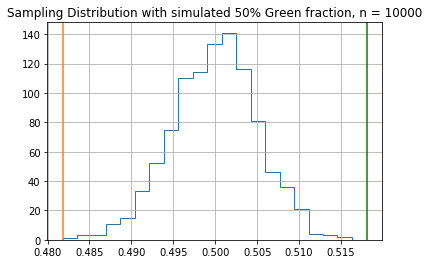

In [26]:
#reuse dist = samplingdist(0.50,10000)
dist.Green.hist(histtype='step', bins=20)
plt.title("Sampling Distribution with simulated 50% Green fraction, n = 10000")
plt.axvline(0.4819,c='C1')
plt.axvline(0.5181,c='g')
plt.draw()

In [27]:
print(quantiles(0.50, 10000))
print(quantiles(1 - 0.518, 10000)) #lower interval
#print(quantiles(0.54)) #upper interval

(0.49079750000000005, 0.5093)
(0.4717, 0.4920025)


It doesn't include the threshold of .50. So now, you can go and write your article.

### Xtra. Duplicate functions for Green
- sampling distribution  
- quantiles  
to validate results of using existing functions coded for Brown but also working for Green

In [28]:
#distGreen = pd.DataFrame([sample(1 - 0.518, 10000).vote.value_counts(normalize=True) for i in range(1000)])
#distGreen.head()
#distGreen.Green.hist(histtype='step', bins=20)

In [29]:
def samplingdistGreen(green,n=10000):
    return pd.DataFrame([sample(1 - green,n).vote.value_counts(normalize=True) for i in range(1000)])

In [30]:
def quantilesGreen(green,n=10000):
    distG = samplingdistGreen(green,n)
    return distG.Green.quantile(0.025), distG.Green.quantile(0.975)

In [31]:
print(quantilesGreen(0.50, 10000))
print(quantilesGreen(0.518, 10000)) #lower interval
#print(quantiles(0.54)) #upper interval

(0.4899975, 0.5090025)
(0.507995, 0.5281025)


It doesn't include the threshold of .50. So now, you can go and write your article.

### Summary
- Look at results of a small poll, n = 1000. Votes Brown vs Green .511 vs .489  
- Can simulate many similar sample polls with this proportion -> notice that Brown doesn't always win, the small poll feels uncertain.  
- Visualize a sampling distribution of 1000 samples, looks like poll estimate doesn't fall far enough from .50  to give confidence. 
- Compute 95% confidence interval = [0.48, 0.54] the election is up for grabs with 0.51 +- .03 margin of error.  
  
How to increase confidence?  Increase the poll size and reevaluate the point estimate.  
- Simulate sample polls, now with n = 10000.  
- Visualize a sampling distribution of 10000 samples.  The margin of error get smaller +- .01. Looks like (the previous) poll estimate falls far from .50 => would give more confidence.  But previous poll results are no longer meaningful.    
- Conduct a larger poll, n = 10000 to get a new vote estimate.  Votes Brown vs Green .482 vs .518  
- Compute 95% confidence interval = [0.509, 0.528] now in favor of Green, the election looks more decisive with 0.518 +- .01 margin of error.  

